In [56]:
from utilities import TimeSeries
from visualisation import plot_kernel_density
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, normaltest, anderson
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [76]:
tsla = TimeSeries('TSLA').construct_returns().dropna().data['Returns'].to_numpy()
sp500 = TimeSeries('SPY').construct_returns().dropna().data['Returns'].to_numpy()



class Regression:
    def __init__(self, Y, X, intercept=True, method='OLS'):
        self.Y = np.array(Y)
        self.X = np.array(X)
        self.intercept = intercept
        self.method = method
        self.model = None
        self.results = None
        
        if self.intercept:
            self.X = sm.add_constant(self.X)
        self.estimate()
    
    def estimate(self):
        if self.method == 'OLS':
            self.model = sm.OLS(self.Y, self.X).fit()  
            self.residuals = self.model.resid
            self.y_pred = self.model.predict(self.X)
            
        return self 
    
    def summary(self):
        print(self.model.summary())
        


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [112]:
from scipy.stats import ttest_1samp

class RegressionDiagonastics:
    def __init__ (self, regression: Regression):
        self.regression = regression

    def check_zero_conditional_mean(self, alpha=0.05):
        residuals = self.regression.residuals
        t_stat, p_value = ttest_1samp(residuals, 0)
        if p_value > alpha:
            conclusion = "The mean of the residuals is not significantly different from zero (p-value = {:.3f}).".format(p_value)
        else:
            conclusion = "The mean of the residuals is significantly different from zero (p-value = {:.3f}).".format(p_value)
        return {
            't_stat': t_stat,
            'p_value': p_value,
            'conclusion': conclusion
        }

    @property
    def residual_mean(self):
        residuals = self.regression.residuals
        mean = np.mean(residuals)
        print(f"Mean of residuals: {mean}")
        return mean
    
    @property
    def residual_variance(self):
        residuals = self.regression.residuals
        variance = np.var(residuals)
        print(f"Variance of residuals: {variance}")
        return variance
    
    

    def check_normality_of_residuals(self):
        residuals = self.regression.residuals
        shapiro_test = shapiro(residuals)
        shapiro_p_value = shapiro_test[1]
        
        # D'Agostino's K-squared test
        k2_test = normaltest(residuals)
        k2_p_value = k2_test[1]
        
        # Anderson-Darling test
        anderson_test = anderson(residuals)
        anderson_statistic = anderson_test.statistic
        anderson_critical_values = anderson_test.critical_values
        anderson_significance_level = anderson_test.significance_level   
        sns.histplot(residuals, kde=True) 
        plt.title('Histogram of Residuals')
        plt.show()      

        sm.qqplot(residuals, line='45')
        plt.title('Q-Q Plot of Residuals')
        plt.show()
        print("Normality of Residuals:")
        if shapiro_p_value > 0.05:
            print("Shapiro-Wilk test: Residuals are normally distributed (p-value = {:.3f}).".format(shapiro_p_value))
        else:
            print("Shapiro-Wilk test: Residuals are not normally distributed (p-value = {:.3f}).".format(shapiro_p_value))
        
        if k2_p_value > 0.05:
            print("D'Agostino's K-squared test: Residuals are normally distributed (p-value = {:.3f}).".format(k2_p_value))
        else:
            print("D'Agostino's K-squared test: Residuals are not normally distributed (p-value = {:.3f}).".format(k2_p_value))
        
        for sig, crit in zip(anderson_significance_level, anderson_critical_values):
            if anderson_statistic < crit:
                print(f"Anderson-Darling test: Residuals are normally distributed at {sig}% significance level.")
            else:
                print(f"Anderson-Darling test: Residuals are not normally distributed at {sig}% significance level.")
        
        return self

    def breusch_pagan_test(self):
        y_pred = self.regression.y_pred
        print(y_pred)
        residuals = self.regression.residuals 
        p = sns.scatterplot(x=y_pred,y=residuals)
        plt.xlabel('y_pred/predicted values')
        plt.ylabel('Residuals')
   
        plt.title('Residuals vs fitted values plot for homoscedasticity check')
        plt.show()

    
    def check_auto_correlation(self):
        from visualisation import plot_acf_pacf_side_by_side
        plot_acf_pacf_side_by_side(self.regression.residuals)
        self.__durbin_watson()
        return self
    
    def __durbin_watson (self):
        dw = sms.stattools.durbin_watson(self.regression.residuals)
        print(f"Durbin-Watson statistic: {dw}")
        if dw < 1.5:
            print("Positive autocorrelationd detected.")
        elif dw > 2.5:
            print("Negative autocorrelation detected.")
        else:
            print("No autocorrelation detected.")
        return self


    

In [113]:
r = Regression(tsla, sp500, intercept=False)
rd = RegressionDiagonastics(r)

Durbin-Watson statistic: 2.006632997061855
No autocorrelation detected.


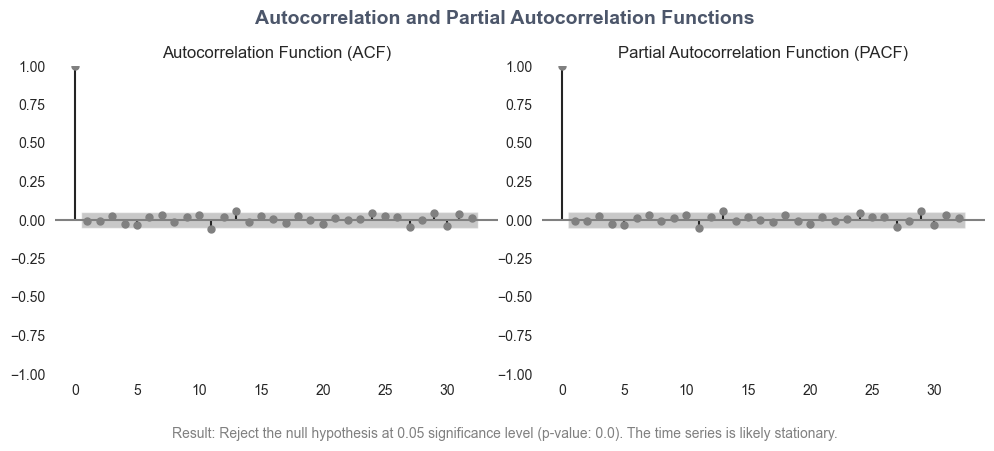

In [115]:
rd.check_auto_correlation()

In [ ]:
r.check_normality_of_residuals()

AttributeError: 'Regression' object has no attribute 'check_normality_of_residuals'